# Ocean Cleanup Analysis

## Introduction

#### Ocean is one of the most valuable natural resources on Earth, but also the terminal of pollution caused by humans. Since ocean cleanup is costly and time-consuming, it is necessary to take some efficient methods to release the beach pollution.

## Objective

#### Analyze and predict the human resource needed, given trashload and location statistics. Predict the number of people needed for ocean cleanup and optimize resource allocation using machine learning algorithms. In this notebook, we have done a basic dataset cleaning as well as a strong prediction model on the cleaned data. 

## Methods

#### Time series forcast, generalized linear models, random forest

### Step1: Import the ocean cleanup dataset and necessary libraries

In [ ]:
%matplotlib inline
%pylab inline

import pandas as pd
import numpy as np
ocean =pd.read_csv('clean4.csv', parse_dates= ['Cleanup Date'])
#df = pd.read_csv(file, sep = ',', parse_dates= [col],encoding='utf-8-sig', usecols= ['Date', 'ids'],)
ocean.head(10)
from datetime import datetime

In [488]:
ocean.shape

(35497, 61)

In [489]:
ocean

,Unnamed: 0,Zone,State,Country,GPS,Cleanup Type,Cleanup Date,Group Name,Adults,Children,...,Other Trash (Clean Swell),Condoms,Diapers,Syringes,Tampons/Tampon Applicators,Personal Hygiene (Clean Swell),Foam Pieces,Glass Pieces,Plastic Pieces,Total Items Collected
0,1,"Cuyahoga County, OH, USA","Ohio, USA",United States,"41.49742, -81.56505","Land (beach, shoreline and inland)",2014-12-22,NaN,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,"Fairfax County, VA, USA","Virginia, USA",United States,"38.87456, -77.24428","Land (beach, shoreline and inland)",2014-12-24,NaN,1,0,...,0,0,0,0,0,0,0,0,2,10
2,3,"Washington, DC, USA","District of Columbia, USA",United States,"38.90733, -77.04405","Land (beach, shoreline and inland)",2015-02-19,NaN,1,0,...,1,0,0,0,0,0,0,0,0,4
3,4,"Washington, DC, USA","District of Columbia, USA",United States,"38.90733, -77.0441","Land (beach, shoreline and inland)",2015-02-19,NaN,1,0,...,0,0,0,0,0,0,0,0,0,14
4,5,"Washington, DC, USA","District of Columbia, USA",United States,"38.90728, -77.04411","Land (beach, shoreline and inland)",2015-03-10,NaN,1,0,...,2,0,0,0,0,1,0,0,1,17
5,6,"Washington, DC, USA","District of Columbia, USA",United States,"38.90745, -77.04423","Land (beach, shoreline and inland)",2015-03-10,NaN,1,0,...,0,0,0,0,0,0,0,0,1,5
6,7,"Washington, DC, USA","District of Columbia, USA",United States,"38.9074, -77.04382","Land (beach, shoreline and inland)",2015-03-18,NaN,1,0,...,0,0,0,0,0,0,0,0,0,8
7,8,"Washington, DC, USA","District of Columbia, USA",United States,"38.90756, -77.04415","Land (beach, shoreline and inland)",2015-03-24,NaN,1,0,...,0,0,0,0,0,0,0,0,2,10
8,9,"Washington, DC, USA","District of Columbia, USA",United States,"38.90738, -77.04383","Land (beach, shoreline and inland)",2015-03-24,NaN,1,0,...,4,0,0,0,0,1,0,0,0,10
9,10,"Washington, DC, USA","District of Columbia, USA",United States,"38.90735, -77.04386","Land (beach, shoreline and inland)",2015-03-24,NaN,1,0,...,1,0,0,0,0,0,0,0,0,10


### Step2: Data Preparation

Here, we have split the GPS location into latitude and longitude with respect to every zone/county. Upon splitting up and getting the latitudes and longitudes as separate columns, we have extracted the state name and country name using the "Area and Census Block API"

We perform this step, because there are many empty State and Zone entries which do not have any geographical data associated with them except for the latitude and longitude

In [490]:
ocean[['Lat','Long']] = ocean.GPS.str.split(",",expand=True,)

ocean = ocean.drop(["GPS"],axis = 1)
df1 = ocean.loc[ocean["Zone"].isna()]
index_df1 = df1.index.tolist()

In [491]:
ocean.loc[ocean.Long.isna()]

,Unnamed: 0,Zone,State,Country,Cleanup Type,Cleanup Date,Group Name,Adults,Children,People,...,Diapers,Syringes,Tampons/Tampon Applicators,Personal Hygiene (Clean Swell),Foam Pieces,Glass Pieces,Plastic Pieces,Total Items Collected,Lat,Long


In [492]:
import urllib, json, requests

zone_list = []
state_list = []

str2 = ""
zone = ""
state = ""
for i in index_df1:
    zone = ""
    state = ""
    str2 = "https://geo.fcc.gov/api/census/area?lat="+str(df1["Lat"][i]).replace(" ","")+"&lon="+str(df1["Long"][i]).replace(" ","")+"&format=json"
    with urllib.request.urlopen(str2) as url:
        data = json.loads(url.read().decode())
        if len(data['results']) != 0:
            #print(data['results'][0]['county_name'])
            zone_list.append(data['results'][0]['county_name'] + " County, " + data['results'][0]['state_code'] + ", USA")
            state_list.append(data['results'][0]['state_name'] + ", USA")
            
            
        else:
            zone_list.append(0)
            state_list.append(0)
            continue

In [493]:
count = 0
for i in range(len(zone_list)):
    if zone_list[i] == 0:
        count +=1
        
print(count)

41


In [494]:
df1['Zone'] = zone_list
df1['State'] = state_list

/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [495]:
count = 0
for i in index_df1:
    ocean['Zone'][i] = zone_list[count]
    ocean['State'][i] = state_list[count]
    count = count + 1

/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In the following cell, we run a test to see if there are any more empty State or Country elements left in either of the two columns. 

In [496]:
count = 0
for i in range(len(zone_list)):
    if ocean['Zone'][i] == 0:
        count +=1
        
print(count)

0


We see that the output of the above cell is 0, which means we have successfully covered all the records in the dataset

In [497]:
ocean.shape

(35497, 62)

In [498]:
#ocean['Cleanup Date'] = np.array(np.datetime64(ocean['Cleanup Date']))

In [499]:
try:
    ocean['Cleanup Date'] = pd.to_datetime(ocean['Cleanup Date'],format='%d/%m/%Y', errors='coerce') 
except:
    ValueError
    
# x[x[:, -1] != 0]

In [500]:
#type(ocean['Cleanup Date'])

ocean['year']=ocean['Cleanup Date'].dt.year 
ocean['month']=ocean['Cleanup Date'].dt.month 
ocean['day']=ocean['Cleanup Date'].dt.day
 

In [501]:
type(ocean['Cleanup Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [502]:
ocean['day_of_week']=ocean['Cleanup Date'].dt.dayofweek 
temp = ocean['Cleanup Date']

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = ocean['Cleanup Date'].apply(applyer) 
ocean['weekend']=temp2

In [503]:
#ocean['weekend']

In [504]:
ocean.columns

Index(['Unnamed: 0', 'Zone', 'State', 'Country', 'Cleanup Type',
       'Cleanup Date', 'Group Name', 'Adults', 'Children', 'People', 'Pounds',
       'Miles', '# of bags', 'Cigarette Butts',
       'Food Wrappers (candy, chips, etc.)',
       'Take Out/Away Containers (Plastic)', 'Take Out/Away Containers (Foam)',
       'Bottle Caps (Plastic)', 'Bottle Caps (Metal)', 'Lids (Plastic)',
       'Straws, Stirrers', 'Forks, Knives, Spoons',
       'Beverage Bottles (Plastic)', 'Beverage Bottles (Glass)',
       'Beverage Cans', 'Grocery Bags (Plastic)', 'Other Plastic Bags',
       'Paper Bags', 'Cups, Plates (Paper)', 'Cups, Plates (Plastic)',
       'Cups, Plates (Foam)', 'Fishing Buoys, Pots & Traps',
       'Fishing Net & Pieces', 'Fishing Line (1 yard/meter = 1 piece)',
       'Rope (1 yard/meter = 1 piece)', 'Fishing Gear (Clean Swell)',
       '6-Pack Holders', 'Other Plastic/Foam Packaging',
       'Other Plastic Bottles (oil, bleach, etc.)', 'Strapping Bands',
       'Tobacco Pac

### Step3: Time Series Analysis for Total Items Collected

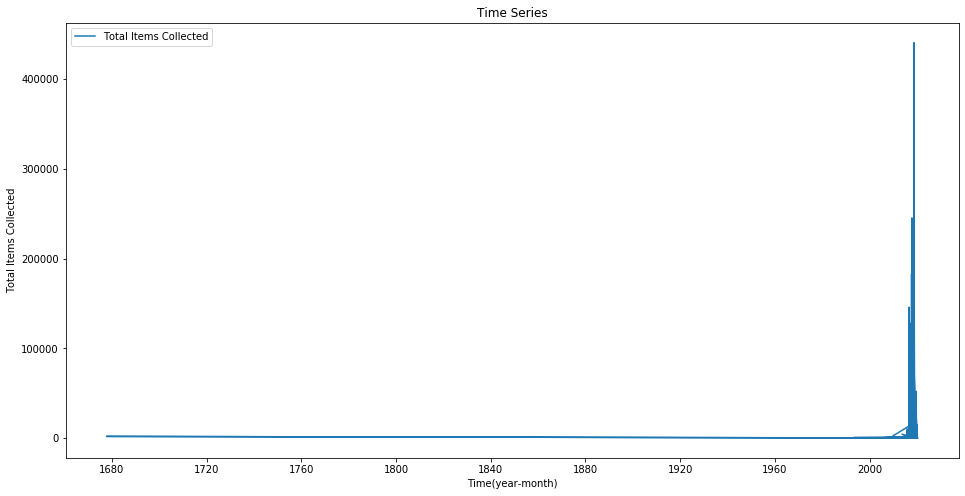

In [505]:
ocean.index = ocean['Cleanup Date'] # indexing the Datetime to get the time period on the x-axis. 
ocean=ocean.drop('Unnamed: 0',1) 
ts = ocean['Total Items Collected'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Total Items Collected') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Total Items Collected") 
plt.legend(loc='best')

In [506]:
#ocean[ocean[:, 6] > '31/12/2014', :]
#z[z[:,0]==6, :]
#ocean[:, 'Cleanup Date'] > '31/12/2014'
ocean.dropna(subset=['Cleanup Date'], inplace=True)

#ocean['Cleanup Date'].isnull().sum()

In [507]:
ocean['Cleanup Date'].isnull().sum()

0

In [508]:
ocean = ocean.loc[(ocean['Cleanup Date'] > '31/12/2014' ) & (ocean['Cleanup Date'] < '01/01/2020')]

In [509]:
ocean = ocean[(ocean.People != 10000)]


In [510]:
ocean.shape

(35304, 66)

In [511]:
ocean = ocean.drop_duplicates()

In [512]:
ocean.shape

(35290, 66)

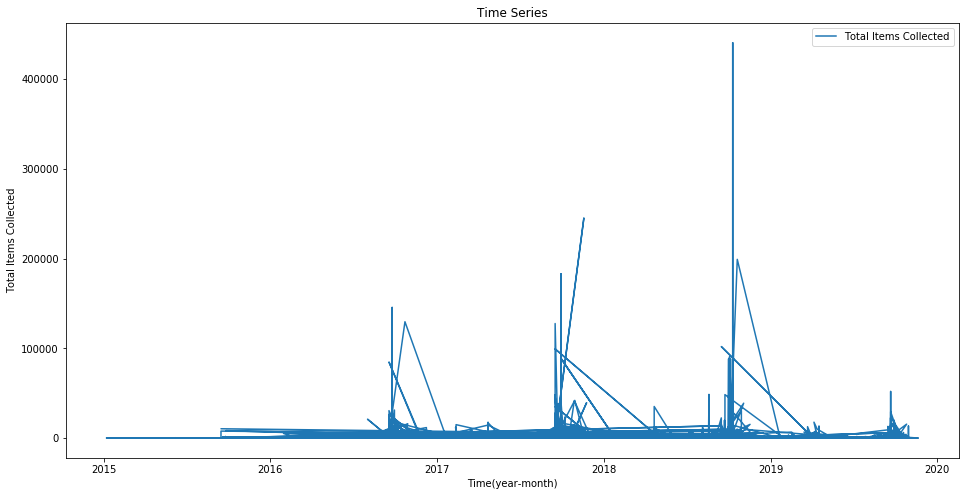

In [513]:
ocean.index = ocean['Cleanup Date'] # indexing the Datetime to get the time period on the x-axis. 
    
ts = ocean['Total Items Collected'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Total Items Collected') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Total Items Collected") 
plt.legend(loc='best')

### Step4: Overview for Beach Cleanup Performance per Year

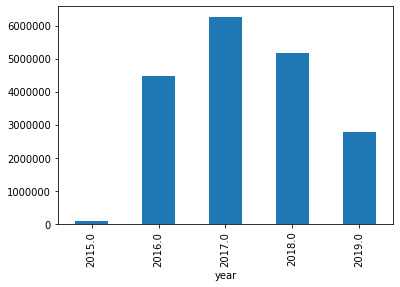

In [514]:
ocean.groupby('year')['Total Items Collected'].sum().plot.bar()

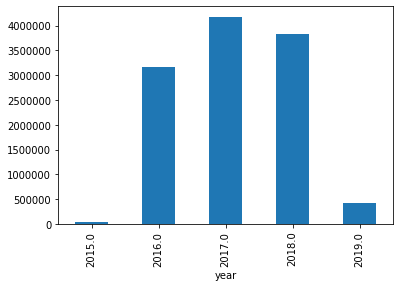

In [515]:
ocean.groupby('year')['Pounds'].sum().plot.bar()

In [516]:
#ocean.to_csv(r'clean7.csv')

In [517]:
ocean['Zone'].isnull().sum()

0

In [518]:
# ocean.isnull().sum()

In [519]:
ocean['State_2'] = ocean.Zone.str[-7:]

In [520]:
# ocean['State_2']

In [521]:
ocean.to_csv(r'clean9.csv')

In [522]:
ocean.month.unique()

array([ 2.,  3.,  4.,  5.,  6.,  8.,  7.,  9., 10., 11., 12.,  1.])

In [525]:
# ocean.to_csv(r'clean9.csv')

In [526]:
# ocean['Plastic'] = ocean['Take Out/Away Containers (Plastic)'] + ocean['Bottle Caps (Plastic)'] + ocean['Lids (Plastic)'] + ocean['Beverage Bottles (Plastic)'] + ocean['Grocery Bags (Plastic)'] + ocean['Other Plastic Bags'] + ocean['Cups, Plates (Plastic)'] + ocean['Other Plastic/Foam Packaging'] + ocean['Other Plastic Bottles (oil, bleach, etc.)'] 

In [527]:
ocean['State'] = ocean['State'].astype('category')
cat_columns = ocean.select_dtypes(['category']).columns
ocean[cat_columns] = ocean[cat_columns].apply(lambda x: x.cat.codes)

In [528]:
(ocean['People']==0).sum()

57

In [529]:
(ocean['Pounds']==0).sum()

6878

In [530]:
ocean = ocean[ocean.People != 0]

In [531]:
(ocean['People']==0).sum()

0

In [532]:
del ocean['Cleanup Date']

In [533]:
ocean = ocean.loc[(ocean['Pounds']/ocean['People'] < 16)]

In [534]:
ocean = ocean.reset_index()

In [535]:
ocean.shape

(31546, 67)

## Step5: Model Selection

In [536]:
ocean_normalizing = ocean.iloc[:,9:59]
ocean_normalizing.reset_index()
ocean_normalizing_columns = ocean_normalizing.columns

In [537]:
#import pandas as pd
from sklearn import preprocessing

x = ocean_normalizing.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ocean_normalized = pd.DataFrame(x_scaled, columns = ocean_normalizing_columns)

In [538]:
ocean_normalized['People'] = ocean['People']
ocean_normalized['weekend'] = ocean['weekend']
ocean_normalized['month'] = ocean['month']

In [539]:
!conda install -c anaconda py-xgboost --yes

In [540]:
train = ocean_normalized[:26622]
test = ocean_normalized[26623:]

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor, plot_importance 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn import metrics
import random 
random.seed(1234)
np.random.seed(1234)

def training (data, predictors, outcome, method):
    if method == 'linear_regression':
        train_model = LinearRegression()
    elif method == 'ridge_regression':
        train_model = Ridge(alpha=0.001)
#         train_model = ElasticNet(alpha=0.05, l1_ratio=0)
    elif method == 'lasso_regression':
        train_model = ElasticNet(alpha=0.001, l1_ratio=1, normalize=True)
    elif method == 'Xgboost':
        train_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
        
        
# Fit the model:
    train_model.fit(data[predictors], data[outcome])

    # Make predictions on the training set:
    predictions = train_model.predict(data[predictors])

    # How well the model fits the training data
    print(method, 'Training RMSE: ', np.sqrt(metrics.mean_squared_error(data[outcome], predictions)))

    #Perform k-fold cross-validation with 10 folds:
    kf = KFold(n_splits=10, random_state=None, shuffle=False)
    error = []

    for train_split, test_split in kf.split(data[predictors]): 
        
        # Filter the training set:
        train_predictors = data[predictors].iloc[train_split, :]
        
        # Filter the target that we are using to train the algorithm:
        train_target = data[outcome].iloc[train_split]

        # Training the algorithm using the predictors and target:
        train_model.fit(train_predictors, train_target)

        test_predictors = data[predictors].iloc[test_split, :]
        test_target = data[outcome].iloc[test_split]
        test_predictions = train_model.predict(test_predictors)

        error.append(np.sqrt(metrics.mean_squared_error(test_predictions, test_target)))
    # How well the model performs on unseen data (not used in train_model.fit())
    print (method, "Cross-Validation RMSE :", np.mean(error))

    # Fit the model again so that it can be refered outside the function:
    train_model.fit(data[predictors],data[outcome])
    return train_model
    
    
def testing(data, predictors, model):
    return model.predict(data[predictors])

outcome_var = 'People'
predictor_var = ['Total Items Collected', 'month', 'weekend', 'Pounds', 'Miles', 'Plastic Pieces', 'Foam Pieces', 'Glass Pieces']

method = 'linear_regression'
train_model = training(train, predictor_var, outcome_var, method)
predictions = testing(test, predictor_var, train_model)

method = 'ridge_regression'
train_model = training(train, predictor_var, outcome_var, method)
predictions = testing(test, predictor_var, train_model)

method = 'lasso_regression'
train_model = training(train, predictor_var, outcome_var, method)
predictions = testing(test, predictor_var, train_model)

method = 'Xgboost'
train_model = training(train, predictor_var, outcome_var, method)
predictions = testing(test, predictor_var, train_model)

linear_regression Training RMSE:  97.39151877768143
linear_regression Cross-Validation RMSE : 86.80289738795292
ridge_regression Training RMSE:  97.39152709703193
ridge_regression Cross-Validation RMSE : 86.71876711627023
lasso_regression Training RMSE:  97.39457253125843
lasso_regression Cross-Validation RMSE : 86.76911709966538
[17:46:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Xgboost Training RMSE:  42.801894214651995
[17:46:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:46:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:47:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:47:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:48:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:48:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:48:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:49:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost Cross-Validation RMSE : 83.56967693018632
[17:49:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


## Step6: Model Validation

In [541]:
a_mean = ocean_normalized.People.mean()
n = ocean_normalized.People.count()
err_mean_sq = 0
for i in ocean_normalized.People:
    err_mean_sq += (i-a_mean)**2/n
RMSE_base = np.sqrt(err_mean_sq)
print(RMSE_base) 
print(a_mean)
print(n)

163.4723686045661
17.22082038927281
31546


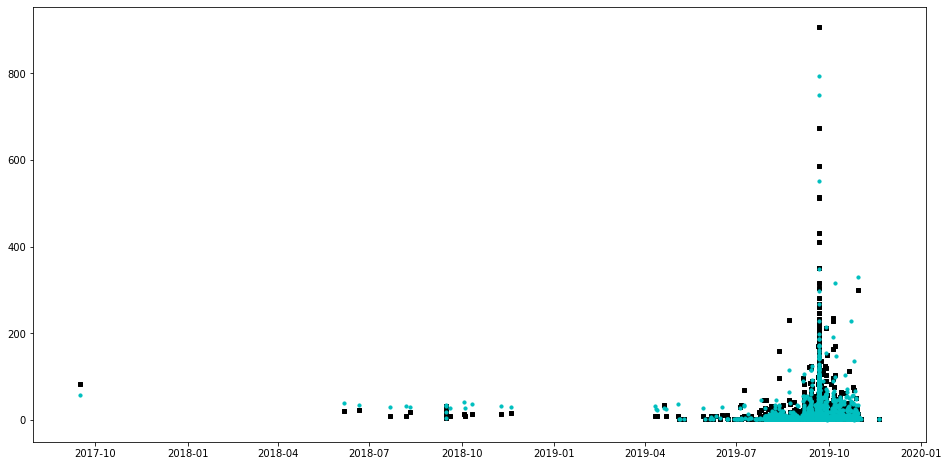

In [559]:
import matplotlib.pyplot as plt

# ocean.index = ocean['Cleanup Date'] # indexing the Datetime to get the time period on the x-axis. 
    
# ts = ocean['Total Items Collected'] 
plt.figure(figsize=(16,8)) 
# plt.plot(ts, label='Total Items Collected') 
# plt.title('Time Series') 
# plt.xlabel("Time(year-month)") 
# plt.ylabel("Total Items Collected") 
# plt.legend(loc='best')

t = ocean['Cleanup Date'][26623:]
a = ocean['People'][26623:]
b = predictions

# plt.plot(t, a, 'r') # plotting t, a separately 
# plt.plot(t, b, 'b') # plotting t, b separately 
# # plt.plot(t, c, 'g') # plotting t, c separately 
# plt.show()

plt = subplot(111)
plt.scatter(t, a, s=10, c='k', marker="s")
plt.scatter(t, b, s=10, c='c', marker="o")
show()